<a href="https://colab.research.google.com/github/juwetta/DLI_Group-B/blob/main/TP074297work/TP074297_FigureRecreate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mount to Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


# **Imports and Setup**


In [2]:
import os, math
import numpy as np
import pandas as pd
import cudf

from cuml.model_selection import train_test_split
from cuml.svm import SVC
from cuml.ensemble import RandomForestClassifier
from cuml.linear_model import LogisticRegression
from cuml.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
SEED=42
np.random.seed(SEED)


In [3]:
# DATA_URL = "https://raw.githubusercontent.com/juwetta/DLI_Group-B/main/URL_dataset_clean_balanced.csv"
# !wget -O URL_dataset_clean_balanced.csv "$DATA_URL"

# df = pd.read_csv("URL_dataset_clean_balanced.csv")

# Paths
SRC = '/content/drive/MyDrive/DLI Group B/url_dataset/URL dataset.csv'
OUT_DIR = '/content/drive/MyDrive/DLI Group B/url_dataset/clean_balanced'
FINAL_CSV = f'{OUT_DIR}/URL_dataset_clean_balanced.csv'

df = pd.read_csv(FINAL_CSV)
df['type'] = df['type'].replace({'legitimate': 0, 'phishing': 1})
ptoc = cudf.DataFrame.from_pandas(df)
print(ptoc.head(2))

/tmp/ipython-input-3513637073.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['type'] = df['type'].replace({'legitimate': 0, 'phishing': 1})


                                                 url  type
0                               http://kitegacc.net/     1
1  https://www.electronichouse.com/article/ps3_ad...     0


In [5]:
all_X = ptoc.iloc[:, :-1]
all_Y = ptoc['type']   # explicitly use "type" column as labels

print("all_X:")
print(all_X.head(5))
print("\nall_Y:")
print(all_Y.head(5))

all_X:
                                                 url
0                               http://kitegacc.net/
1  https://www.electronichouse.com/article/ps3_ad...
2      https://www.linkedin.com/in/larrymartinkimpel
3  https://www.kansascity.com/2011/03/05/2700249/...
4        https://www.en.wikipedia.org/wiki/Dem_Bones

all_Y:
0    1
1    0
2    0
3    0
4    0
Name: type, dtype: int64


# **Splitting Data**

In [6]:
X_train, X_test, y_train, y_test = train_test_split(all_X, all_Y, test_size=0.5, random_state=SEED, stratify=all_Y)

print("Train:", X_train.shape, y_train.shape, "Test:", X_test.shape, y_test.shape)

Train: (104438, 1) (104438,) Test: (104438, 1) (104438,)


# **Utility Functions**

In [7]:
def to_numpy_safe(y):
    """Convert cudf, cuml, cupy, numpy into numpy array safely"""
    if hasattr(y, "to_numpy"): return y.to_numpy()
    if hasattr(y, "to_output"): return y.to_output("numpy")
    if hasattr(y, "get"): return y.get()
    return np.asarray(y)

def preprocess_dataframe(df):
    """Convert object/categorical cols to integer codes for GPU models"""
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].astype('category')
        if str(df[col].dtype) == 'category':
            df[col] = df[col].cat.codes.astype('int32')
    return df

def metrics_cal(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()

    total = TP + TN + FP + FN
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    f1 = (2*precision*recall) / (precision+recall) if (precision+recall) > 0 else 0
    acc = (TP + TN) / total
    return {"Accuracy": acc, "Precision": precision, "Recall": recall, "F1": f1, "Specificity": specificity}


def metrics_cal2(conf_mat):
  print(conf_mat)
  TP = conf_mat[0][0]
  FP = conf_mat[0][1]
  FN = conf_mat[1][0]
  TN = conf_mat[1][1]

  total = TP+FP+TN+FN
  TPR = TP/float(TP+FN)
  TNR = TN/float(TN+FP)
  Precision = TP/float(TP+FP)
  f_score = (2*TPR*Precision)/(TPR+Precision)
  MCC = ((TP * TN) - (FP * FN)) / math.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
  ACC = (TP + TN) / (total)
  print('TPR :=', TPR, 'TNR:=', TNR, 'Precision := ', Precision, 'F_score:=', f_score, 'MCC := ', MCC, 'ACC := ', ACC)


# ***Base Models***

In [8]:
def get_models():
    models = list()
    models.append(XGBClassifier(device="cuda", n_estimators=200, learning_rate=0.1, max_depth=5,
                                subsample=0.8, colsample_bytree=0.8, eval_metric="logloss", tree_method="hist"))
    models.append(SVC(probability=True, C=2.0, kernel="rbf"))
    models.append(KNeighborsClassifier(n_neighbors=5))
    models.append(LogisticRegression(class_weight="balanced", max_iter=500))
    models.append(RandomForestClassifier(n_estimators=300, max_depth=15))

    return models

models = get_models()

# ***Out-of-Fold Predictions (Stacking)***

In [9]:
def get_out_of_fold_predictions(X_train, Y_train, models, n_splits=10):
    meta_X, meta_y = [], []
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

    X_train = preprocess_dataframe(X_train.copy())
    Y_train_np = to_numpy_safe(Y_train)   # ensure numpy

    for train_ix, test_ix in kfold.split(X_train, Y_train_np):
        train_X, test_X = X_train.iloc[train_ix], X_train.iloc[test_ix]
        train_y, test_y = Y_train_np[train_ix], Y_train_np[test_ix]  # already numpy
        meta_y.extend(test_y.tolist())

        fold_preds = []
        for model in models:
            model.fit(train_X, train_y)
            yhat = model.predict_proba(test_X)
            yhat = to_numpy_safe(yhat)
            fold_preds.append(yhat)

        meta_X.append(np.hstack(fold_preds))

    return np.vstack(meta_X), np.asarray(meta_y)

# Fit Base + Meta Model

In [10]:
meta_X, meta_y = get_out_of_fold_predictions(X_train, y_train, models)

# Stronger meta model
meta_model = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=4,
                           subsample=0.8, colsample_bytree=0.8, eval_metric="logloss")
meta_model.fit(meta_X, meta_y)

[2025-08-24 13:21:39.493] [CUML] [warning] L-BFGS line search failed (code 4); stopping at the last valid step
[2025-08-24 13:21:42.546] [CUML] [warning] L-BFGS line search failed (code 4); stopping at the last valid step
[2025-08-24 13:21:44.527] [CUML] [warning] L-BFGS line search failed (code 4); stopping at the last valid step
[2025-08-24 13:21:46.626] [CUML] [warning] L-BFGS line search failed (code 4); stopping at the last valid step
[2025-08-24 13:21:49.365] [CUML] [warning] L-BFGS line search failed (code 4); stopping at the last valid step
[2025-08-24 13:21:51.829] [CUML] [warning] L-BFGS line search failed (code 4); stopping at the last valid step
[2025-08-24 13:21:53.934] [CUML] [warning] L-BFGS line search failed (code 4); stopping at the last valid step
[2025-08-24 13:21:55.914] [CUML] [warning] L-BFGS line search failed (code 4); stopping at the last valid step
[2025-08-24 13:21:58.213] [CUML] [warning] L-BFGS line search failed (code 4); stopping at the last valid step
[

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

# **Evaluate Meta Model**

+------------------------+------------+-------------+----------+------------+-----------+------------------------+-----------------+
| Model                  |   Accuracy |   Precision |   Recall |   F1 Score |   ROC-AUC | Params                 |   Inference(ms) |
+========================+============+=============+==========+============+===========+========================+=================+
| Super Learner Ensemble |     99.465 |      99.786 |   99.142 |     99.463 |    99.877 | trees=300, max_depth=4 |           0.003 |
+------------------------+------------+-------------+----------+------------+-----------+------------------------+-----------------+


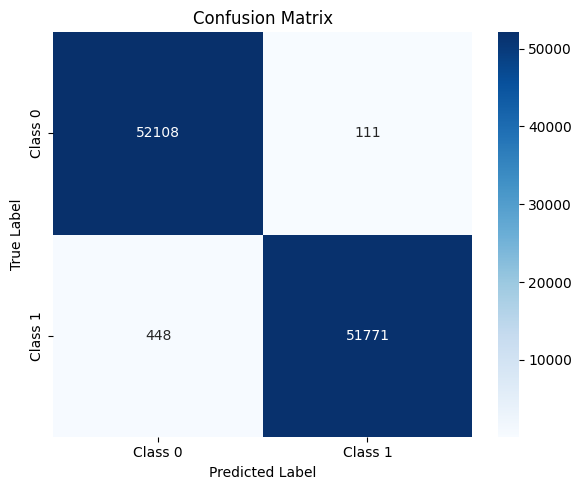

In [13]:
import time, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from tabulate import tabulate
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)

# Helper: convert labels to ints; also return pretty axis names
def to_int_and_names(y, positive_label="phishing"):
    y = np.asarray(y)
    if y.dtype.kind in "OUS":        # string/object labels
        y_int = (y == positive_label).astype(int)
        names = ("Legitimate", "Phishing")
    else:                            # numeric 0/1
        y_int = y.astype(int)
        names = ("Class 0", "Class 1")
    return y_int, names

# Inference & predictions
t0 = time.time()
y_pred = meta_model.predict(meta_X)
t1 = time.time()
inference_ms = (t1 - t0) / len(meta_y) * 1000

# Normalize labels/preds to ints for metrics, and get axis names
y_true_int, axis_names = to_int_and_names(meta_y)
if np.asarray(y_pred).dtype.kind in "OUS":
    y_pred_int, _ = to_int_and_names(y_pred)
else:
    y_pred_int = np.asarray(y_pred).astype(int)

# Metrics (percent)
acc  = accuracy_score(y_true_int, y_pred_int) * 100
prec = precision_score(y_true_int, y_pred_int, zero_division=0) * 100
rec  = recall_score(y_true_int, y_pred_int, zero_division=0) * 100
f1   = f1_score(y_true_int, y_pred_int, zero_division=0) * 100

# ROC-AUC (if predict_proba available)
try:
    y_prob = meta_model.predict_proba(meta_X)[:, 1]
    roc_auc = roc_auc_score(y_true_int, y_prob) * 100
    roc_str = f"{roc_auc:.3f}"
except Exception:
    roc_str = "N/A"

# Build & print ASCII table
results = pd.DataFrame([{
    "Model": "Super Learner Ensemble",
    "Accuracy": f"{acc:.3f}",
    "Precision": f"{prec:.3f}",
    "Recall": f"{rec:.3f}",
    "F1 Score": f"{f1:.3f}",
    "ROC-AUC": roc_str,
    "Params": f"trees={meta_model.n_estimators}, max_depth={meta_model.max_depth}",
    "Inference(ms)": f"{inference_ms:.3f}"
}])
print(tabulate(results, headers="keys", tablefmt="grid", showindex=False))

# Confusion Matrix (and save)
cm = confusion_matrix(y_true_int, y_pred_int, labels=[0, 1])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[axis_names[0], axis_names[1]],
            yticklabels=[axis_names[0], axis_names[1]])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=150)
plt.show()



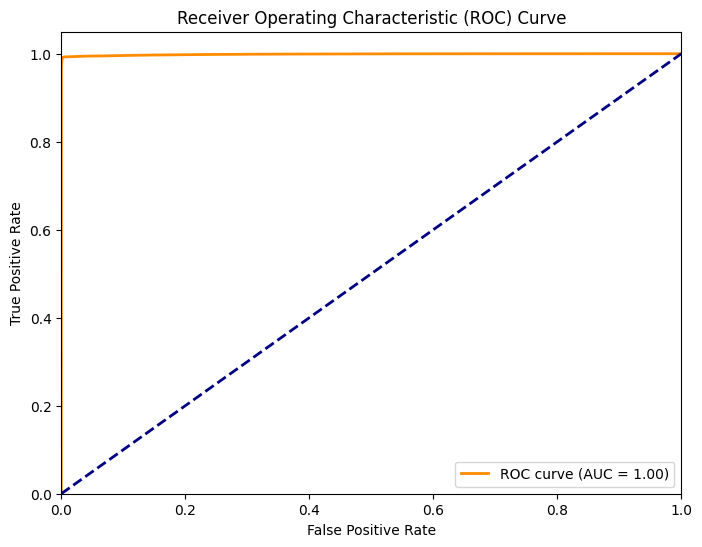

In [14]:
#Insert ROC Curve(and save)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true_int, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()